In [1]:
import pandas as pd
from pathlib import Path
import glob
import dask.dataframe as dd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Read all files in `data/`, loading only 2 columns (e.g. 'NSPIKES' and 'WAVELNTH'). 
# You will probably add another 3rd column to correlate it with NSPIKES or something.
df = dd.read_parquet("/mnt/data2/SDO/AIA/parquet/", columns=['NSPIKES', 'WAVELNTH'])
# Get the spikes for wavelength 171, convert to int32 for less memory. 
nspikes = df[df['WAVELNTH'] == 171]['NSPIKES'].astype(np.uint32)
# Have a glance at the few first rows of that processing
nspikes.head()

T_OBS
2010-06-01 00:00:06.570000+00:00    18976
2010-06-01 00:00:18.570000+00:00    18866
2010-06-01 00:00:36.550000+00:00    21689
2010-06-01 00:00:48.580000+00:00    20180
2010-06-01 00:01:00.560000+00:00    21066
Name: NSPIKES, dtype: uint32

In [3]:
# Resample to every 48s using the mean of the 4x 12s bins. Nearest neighbor is only available in pandas. 
nspikes = nspikes.resample('48s').mean()
# Have a glance at the few first rows of that processing
nspikes.head()

T_OBS
2010-06-01 00:00:00+00:00    19843.666667
2010-06-01 00:00:48+00:00    20520.000000
2010-06-01 00:01:36+00:00    20744.750000
2010-06-01 00:02:24+00:00    21945.500000
2010-06-01 00:03:12+00:00    21605.250000
Freq: 48S, Name: NSPIKES, dtype: float64

In [4]:
# At this time, Dask just built a computational graph of what processes were asked. 
# It has not computed any data. Printing the data only shows the time index and few other info.
print(nspikes)

Dask Series Structure:
npartitions=13
2010-06-01 00:00:00+00:00    float64
2011-01-01 00:00:00+00:00        ...
                              ...   
2021-12-31 23:59:12+00:00        ...
2022-06-10 00:00:00+00:00        ...
Name: NSPIKES, dtype: float64
Dask Name: resample, 130 tasks


In [5]:
# Trigger the full processing with compute() to get the data processed and into a Pandas dataframe. 
nspikes_df = nspikes.compute()

In [6]:
# This time everything has computed, you see mean values every 48s, from 2010 to 2022
print(nspikes_df)

T_OBS
2010-06-01 00:00:00+00:00    19843.666667
2010-06-01 00:00:48+00:00    20520.000000
2010-06-01 00:01:36+00:00    20744.750000
2010-06-01 00:02:24+00:00    21945.500000
2010-06-01 00:03:12+00:00    21605.250000
                                 ...     
2022-06-09 23:56:48+00:00      619.250000
2022-06-09 23:57:36+00:00      611.250000
2022-06-09 23:58:24+00:00      655.250000
2022-06-09 23:59:12+00:00      599.000000
2022-06-10 00:00:00+00:00      608.000000
Freq: 48S, Name: NSPIKES, Length: 7905601, dtype: float64


<AxesSubplot:xlabel='T_OBS'>

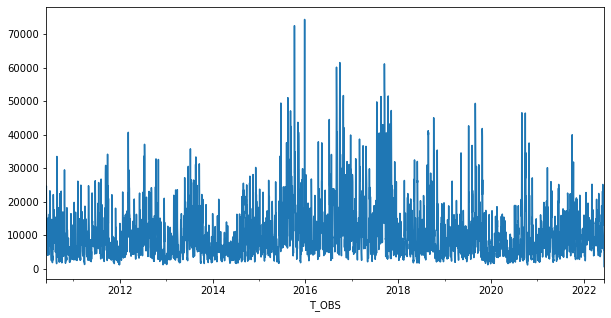

In [7]:
# Plot them over the 11 years, no need to have the 48s, you can again resample at, say '24h'
# This time everything is in memory as a pandas dataframe, no need to call compute()
fig = plt.figure(figsize=[10, 5])
nspikes_df.resample('24h').mean().plot()